Donwload the ephimeres data for Neptune, Uranus, Saturn and Jupiter from the following lik and upload it in the notebook's files before running the code:
https://drive.google.com/drive/folders/1jTIP4iSCrfoqdKXt4sUcwocLxYqIx8uG?usp=sharing

In [1]:
from scipy.signal import medfilt, find_peaks
from astroquery.jplhorizons import Horizons
import matplotlib.pyplot as plt
from scipy.constants import G
from astropy.time import Time
import scipy.optimize as sc
import numpy as np
import math
%matplotlib inline

## On importe les Ephemeris des corps important sur la trajectoire d'Uranus

In [2]:
annee_start = 1780
annee_fin = 2040

# On importe la position des 4 planètes
neptune = Horizons(id="8", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Neptune")
uranus = Horizons(id="7", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Uranus")
saturne = Horizons(id="6", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Saturne")
jupiter = Horizons(id="5", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Jupiter")
mars = Horizons(id="4", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Mars")
terre = Horizons(id="3", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Terre")
venus = Horizons(id="2", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Venus")
mercure = Horizons(id="1", location="@sun", epochs={'start': f"{annee_start}-01-02", 'stop': f"{annee_fin}-01-01",'step': '30d'}, id_type=None).vectors()
print("Import Mercure")

Neptune = np.stack([np.array(neptune[:]["x"]),np.array(neptune[:]["y"]),np.array(neptune[:]["z"])],axis=1)
Uranus = np.stack([np.array(uranus[:]["x"]),np.array(uranus[:]["y"]),np.array(uranus[:]["z"])],axis=1)
Saturn = np.stack([np.array(saturne[:]["x"]),np.array(saturne[:]["y"]),np.array(saturne[:]["z"])],axis=1)
Jupiter = np.stack([np.array(jupiter[:]["x"]),np.array(jupiter[:]["y"]),np.array(jupiter[:]["z"])],axis=1)
Mars = np.stack([np.array(mars[:]["x"]),np.array(mars[:]["y"]),np.array(mars[:]["z"])],axis=1)
Terre = np.stack([np.array(terre[:]["x"]),np.array(terre[:]["y"]),np.array(terre[:]["z"])],axis=1)
Venus = np.stack([np.array(venus[:]["x"]),np.array(venus[:]["y"]),np.array(venus[:]["z"])],axis=1)
Mercure = np.stack([np.array(mercure[:]["x"]),np.array(mercure[:]["y"]),np.array(mercure[:]["z"])],axis=1)
# On importe les vitesses d'uranus
Uv = np.stack([np.array(uranus[:]["vx"]),np.array(uranus[:]["vy"]),np.array(uranus[:]["vz"])],axis=1)
Uv=Uv*365.24218750 # Convertir de AU/Jour en AU/an

Import Neptune
Import Uranus
Import Saturne
Import Jupiter
Import Mars
Import Terre
Import Venus
Import Mercure


## On définit notre intervalle de temps et d'autres valeurs importantes

In [3]:
Time=np.array(range(Uranus.shape[0]))
Time=Time/(365.24218750/30)+annee_start
Time_no_buffer = Time.copy()
G=G*(365.24218750*86400)**2/(149597870700)**3 #Conversion de kg(UA)^3/(année)^2
M_N = 1.024e26

## On calcule la variation de l'accélération due à Neptune de façon théorique

In [4]:
# Calcul de V en utilisant Les valeurs de Neptune pour vérifier 
# si le bon graphique peut être obtenu

# rel_pos : position relative de neptune à uranus
# r_NU3 : distance entre Neptune et Uranus au cube
# r_NS3 : distance entre Neptune et le soleil au cube
# A_by_N_théo : accélération théorique causé par Neptune sur Uranus

rel_pos = Neptune-Uranus

Nx,Ny,Nz = Neptune.T
Ux,Uy,Uz = Uranus.T

r_NU3 = ((Nx-Ux)**2+(Ny-Uy)**2+(Nz-Uz)**2)**(3/2) #10^3

r_NU3 = np.tile(r_NU3, (3,1))
r_NU3 = np.transpose(r_NU3)

r_NS3 = ((Nx)**2+(Ny)**2+(Nz)**2)**(3/2) #10^3

r_NS3 = np.tile(r_NS3, (3,1))
r_NS3 = np.transpose(r_NS3)

A_by_N_théo = G*M_N*(rel_pos/r_NU3 - Neptune/r_NS3)

## On évalue au premier terme l'accélération totale d'Uranus et on lui soustrait les influences des 2e et 3e termes de son accélération, soit celles due au soleil et aux autres planètes. 

$\vec{A} (t) = \frac{d^2 \vec{r_U}}{dt^2} + G(M_{\bigodot}+M_U) \frac{r_U}{|r_U|^3} - \sum^9_{j \ne \bigodot, U, N} G M_j \Big( \frac{\vec{r_j} - \vec{r_U} }{ |\vec{r_j} - \vec{r_U}|^3 } - \frac{\vec[r_j]}{|r_j|^3} \Big)$

In [5]:
#On compute la variable V en utilisant la méthode RHS
buffer = 5
Time = Time[buffer:-buffer]

# r_US3 : distance entre Uranus et le soleil au cube
# A_by_N_T2 : Deuxième terme de l'accélération causé par Neptune sur Uranus
# r_StS3 : distance entre Saturne et le soleil au cube
# r_USt3 : distance entre Uranus et Saturne au cube
# r_UJ3 : distance entre Uranus et Jupiter au cube
# r_JS3 : distance entre Jupiter et le soleil au cube

M_S = 1.989e30 #Masse du Soleil
M_U = 8.681e25 #Masse d'Uranus
M_St = 5.683e26 #Masse de Saturne
M_J = 1.898e27 #Masse de Jupiter
M_Ma = 6.417e23 #Masse de Mars
M_T = 5.972e24 #Masse de la Terre
M_V = 4.867e24 #Masse de Vénus
M_Me = 3.285e23 #Masse de Mercure

# On obtient l'accélération d'Uranus en utilisant la 
#méthode "Five-point stencil" du vecteur de vitesse

#############
#Premier Terme
#############

dt = 30/365.24218750 # L'intervalle de temps entre deux points consécutifs en année
A_by_N_T1 = np.tile(np.zeros(Uranus.shape[0]),(3,1))

A_by_N_T1 = np.transpose(A_by_N_T1)
for i in range(Uranus.shape[0]-2):
    if i not in [0,1]:
        A_by_N_T1[i]=1/(12*dt)*(Uv[i-2]-8*Uv[i-1]+8*Uv[i+1]-Uv[i+2])

#############
#Deuxième Terme
#############

r_US3 = np.sqrt((Ux**2)+(Uy**2)+(Uz**2))**3
r_US3 = np.tile(r_US3, (3,1))
r_US3 = np.transpose(r_US3)

A_by_N_T2 = G*(M_S+M_U)*Uranus/(r_US3)

############
#Troisième Terme
############

#Saturn
Sx,Sy,Sz=Saturn.T

r_USt3 =((Sx-Ux)**2+(Sy-Uy)**2+(Sz-Uz)**2)**(3/2)
r_USt3 = np.tile(r_USt3, (3,1))
r_USt3 =np.transpose(r_USt3)

r_StS3 =((Sx)**2+(Sy)**2+(Sz)**2)**(3/2)
r_StS3 = np.tile(r_StS3, (3,1))
r_StS3 =np.transpose(r_StS3)

S = G*M_St*((Saturn-Uranus)/r_USt3 - Saturn/r_StS3)

#Jupiter
Jx,Jy,Jz=Jupiter.T

r_UJ3 = ((Jx-Ux)**2+(Jy-Uy)**2+(Jz-Uz)**2)**(3/2)
r_UJ3 = np.tile(r_UJ3, (3,1))
r_UJ3 = np.transpose(r_UJ3)

r_JS3 = ((Jx)**2+(Jy)**2+(Jz)**2)**(3/2)
r_JS3 = np.tile(r_JS3, (3,1))
r_JS3 = np.transpose(r_JS3)

J = G*M_J*((Jupiter-Uranus)/r_UJ3 - Jupiter/r_JS3)

#Mars
Max,May,Maz=Mars.T

r_UMa3 = ((Max-Ux)**2+(May-Uy)**2+(Maz-Uz)**2)**(3/2)
r_UMa3 = np.tile(r_UMa3, (3,1))
r_UMa3 = np.transpose(r_UMa3)

r_MaS3 = ((Max)**2+(May)**2+(Maz)**2)**(3/2)
r_MaS3 = np.tile(r_MaS3, (3,1))
r_MaS3 = np.transpose(r_MaS3)

Ma = G*M_Ma*((Mars-Uranus)/r_UMa3 - Mars/r_MaS3)

#Terre
Tx,Ty,Tz=Terre.T

r_UT3 = ((Tx-Ux)**2+(Ty-Uy)**2+(Tz-Uz)**2)**(3/2)
r_UT3 = np.tile(r_UT3, (3,1))
r_UT3 = np.transpose(r_UT3)

r_TS3 = ((Tx)**2+(Ty)**2+(Tz)**2)**(3/2)
r_TS3 = np.tile(r_TS3, (3,1))
r_TS3 = np.transpose(r_TS3)

T = G*M_T*((Terre-Uranus)/r_UT3 - Terre/r_TS3)

#Venus
Vx,Vy,Vz=Venus.T

r_UV3 = ((Vx-Ux)**2+(Vy-Uy)**2+(Vz-Uz)**2)**(3/2)
r_UV3 = np.tile(r_UV3, (3,1))
r_UV3 = np.transpose(r_UV3)

r_VS3 = ((Vx)**2+(Vy)**2+(Vz)**2)**(3/2)
r_VS3 = np.tile(r_VS3, (3,1))
r_VS3 = np.transpose(r_VS3)

V = G*M_V*((Venus-Uranus)/r_UV3 - Venus/r_VS3)

#Mercure
Mex,Mey,Mez=Mercure.T

r_UMe3 = ((Mex-Ux)**2+(Mey-Uy)**2+(Mez-Uz)**2)**(3/2)
r_UMe3 = np.tile(r_UMe3, (3,1))
r_UMe3 = np.transpose(r_UMe3)

r_MeS3 = ((Mex)**2+(Mey)**2+(Mez)**2)**(3/2)
r_MeS3 = np.tile(r_MeS3, (3,1))
r_MeS3 = np.transpose(r_MeS3)

Me = G*M_Me*((Mercure-Uranus)/r_UMe3 - Mercure/r_MeS3)

A_by_N_T3 = J+S+Ma+T+V+Me

# On applique le buffer
A_by_N_T1 = A_by_N_T1[buffer:-buffer,:]
A_by_N_T2 = A_by_N_T2[buffer:-buffer,:]
A_by_N_T3 = A_by_N_T3[buffer:-buffer,:]

A_by_N_théo = A_by_N_théo[buffer:-buffer,:]

## Ici on regarde l'influence de chacun des termes

In [6]:
# On prend les coordonnées du premier terme de V2
A_by_N_T1x, A_by_N_T1y, A_by_N_T1z = A_by_N_T1.T
A_by_N_T1_mag =((A_by_N_T1x)**2+(A_by_N_T1y)**2+(A_by_N_T1z)**2)**(1/2)

# On prend les coordonnées du deuxième terme de V2
A_by_N_T2x, A_by_N_T2y, A_by_N_T2z = A_by_N_T2.T
A_by_N_T2_mag = ((A_by_N_T2x)**2+(A_by_N_T2y)**2+(A_by_N_T2z)**2)**(1/2)

# On prend les coordonnées du troisième terme de V2
A_by_N_T3x, A_by_N_T3y, A_by_N_T3z = A_by_N_T3.T
A_by_N_T3_mag =((A_by_N_T3x)**2+(A_by_N_T3y)**2+(A_by_N_T3z)**2)**(1/2)

In [7]:
A_by_N = A_by_N_T1+A_by_N_T2-A_by_N_T3
A_by_Nx, A_by_Ny, A_by_Nz = A_by_N.T
A_by_N_mag =((A_by_Nx)**2+(A_by_Ny)**2+(A_by_Nz)**2)**(1/2)

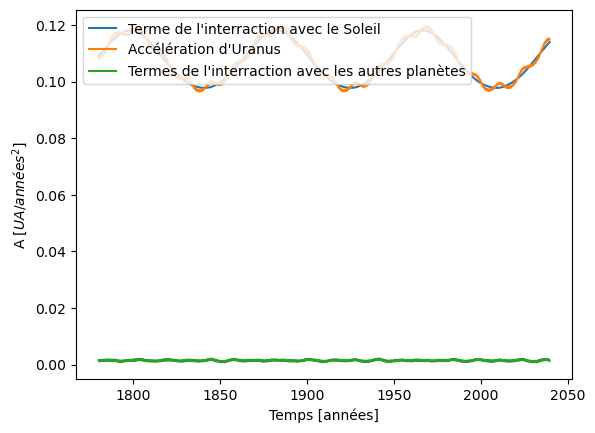

In [8]:
plt.plot(Time,A_by_N_T2_mag,label="Terme de l'interraction avec le Soleil")
plt.plot(Time,A_by_N_T1_mag,label="Accélération d'Uranus")
plt.plot(Time,A_by_N_T3_mag,label="Termes de l'interraction avec les autres planètes")
plt.legend(loc="upper left")
plt.xlabel("Temps [années]")
plt.ylabel("A $[UA/années^2]$")
plt.show()

## Filtrage de l'accélération pour limiter les erreurs

In [9]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
kernel = 301
filter_buffer = int((kernel-1)/2)

théo_x,théo_y,théo_z = A_by_N_théo.T
exp_x, exp_y, exp_z = A_by_N.T
mean_x = moving_average(exp_x,kernel)
mean_y = moving_average(exp_y,kernel)
mean_z = moving_average(exp_z,kernel)

## Calculons la période synodique en utilisant la quantité scalaire $\chi (t)$ qui est la projection de l'accélération d'Uranus dans la direction de son déplacement (donc le long de sa trajectoire autour du soleil)

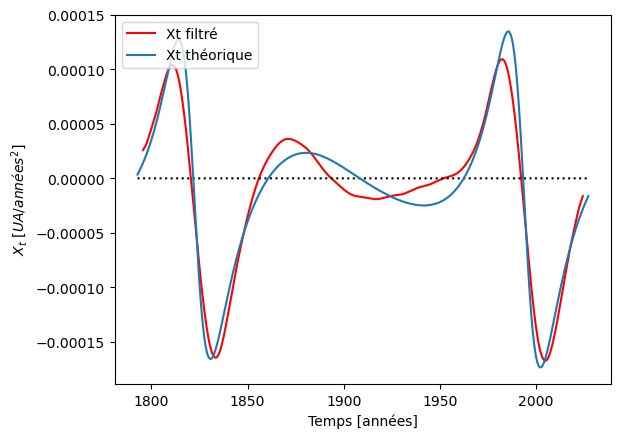

In [10]:
Ax,Ay,Az = mean_x,mean_y,mean_z
Ax_t,Ay_t,Az_t = A_by_N_théo[filter_buffer:-filter_buffer,:].T

Z=np.zeros(Uranus.shape[0])
Z=np.tile(Z,(3,1))
Z=np.transpose(Z)
for i in range(Uranus.shape[0]):
  Z[i,2]=1

p_t = np.cross(Z,Uranus) # p_t est le plan xy qui est toujours perpendiculaire à r_U
px,py,pz = p_t[buffer:-buffer,:][filter_buffer:-filter_buffer,:].T

Xt_theorique =Ax_t*px + Ay_t*py + Az_t*pz
Xt = Ax*px + Ay*py + Az*pz
 
Xt_fft = np.fft.fft(Xt)
Xt_fft[50:-50] = 0
Xt_filtre = np.fft.ifft(Xt_fft).real

buffer_fft = 35
kernel_fft = buffer_fft-10
Xt_filtre = moving_average(Xt_filtre,kernel_fft)
buffer_supp = int((buffer_fft-(kernel_fft-1)/2))
Xt_filtre = Xt_filtre[buffer_supp:-buffer_supp]

# ici des buffer sont utiliser pour crop les extrémités bruités à cause des effets de bord
plt.plot(Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft],Xt_filtre, label="Xt filtré", color="r")

Zero=np.zeros(len(mean_x))
Zero=np.array(Zero)
plt.plot(Time[filter_buffer:-filter_buffer],Zero, color="k", linestyle=":")
plt.plot(Time[filter_buffer:-filter_buffer],Xt_theorique, label="Xt théorique")
plt.xlabel("Temps [années]")
plt.ylabel("$X_t$ $[UA/années^2]$")
plt.legend(loc="upper left")
plt.show()

## On trouve les passages à 0 après les deux gros pics positifs (ce qui correspond à la conjonction de nos astres)

In [34]:
def intersection(X,Y):
	ind = []
	xs = []
	for i in range(len(Y)-1):
		if Y[i] ==0:
			xs.append(X[i])
			ind.append(i)
		elif (Y[i] < 0 and Y[i+1] > 0):
			xs.append(X[i])
			ind.append(i)
		elif (Y[i] > 0 and Y[i+1] < 0):
			xs.append(X[i])
			ind.append(i)
	return xs, ind

intersect, indice_conjonction = intersection(Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft],Xt_filtre)

conj1,conj2 = intersect[0],intersect[-1]

p_synodic = conj2-conj1

print(72*"#"+"\n"+72*"#")
print("La période synodique prédite de Neptune avec Uranus est :",np.round(p_synodic,1),"années")
print("La période synodique théorique de Neptune avec Uranus est :",171.4,"années")
print(72*"#"+"\n"+72*"#")

########################################################################
########################################################################
########################################################################
La période synodique prédite de Neptune avec Uranus est : 171.7 années
La période synodique théorique de Neptune avec Uranus est : 171.4 années
########################################################################
########################################################################


## On calcul la période sidérale

In [37]:
p_U = 84.01 # ans
p_N = (p_U*p_synodic)/( p_synodic-p_U )

print(60*"#"+"\n"+60*"#")
print("La période sidérale prédite de Neptune est :",np.round(p_N,2), "années")
print("La période sidérale théorique de Neptune est :",164.79, "années")
print(60*"#"+"\n"+60*"#")

############################################################
############################################################
La période sidérale prédite de Neptune est : 164.45 années
La période sidérale théorique de Neptune est : 164.79 années
############################################################
############################################################


## On calcul le demi grand-axe

In [40]:
# En utilisant la 3ième loi de Kepler
demi_grand_axe_N = p_N**(2/3)

print(53*"#"+"\n"+53*"#")
print("Le demi grand-axe prédit de Neptune est :", np.round(demi_grand_axe_N,2), "ua")
print("Le demi grand-axe théorique de Neptune est :", 30.07, "ua")
print(53*"#"+"\n"+53*"#")

#####################################################
#####################################################
Le demi grand-axe prédit de Neptune est : 30.02 ua
Le demi grand-axe théorique de Neptune est : 30.07 ua
#####################################################
#####################################################


## On estime la masse de Neptune en utilisant les 2 conjonctions

In [54]:
# On a fait l'analyse en utilisant Xi(t) donc on n'utilise que les données en 2d (x,y)

ind_1 = indice_conjonction[0]

Uxy_1 = Uranus[buffer:-buffer][filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_1][:2]
Ux1,Uy1 = Uxy_1

r_U1 = np.sqrt(Ux1**2+Uy1**2)

ratio = demi_grand_axe_N/r_U1
Nxy_1 = Uxy_1*ratio
A_by_N_filter_1 = np.stack([mean_x[buffer_fft:-buffer_fft],mean_y[buffer_fft:-buffer_fft],mean_z[buffer_fft:-buffer_fft]])[:,ind_1][:2]

r_UN_1 = np.sqrt((Nxy_1[0]-Uxy_1[0])**2+(Nxy_1[1]-Uxy_1[1])**2)
r_N_1 = np.sqrt((Nxy_1[0])**2+(Nxy_1[1])**2)

M_N_1 = (A_by_N_filter_1/G)/( (Nxy_1 - Uxy_1)/(r_UN_1**3) - Nxy_1/(np.abs(r_N_1)**3) )

ind_2 = indice_conjonction[-1]

Uxy_2 = Uranus[buffer:-buffer][filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_2][:2]
Ux2,Uy2 = Uxy_2

r_U2 = np.sqrt(Ux2**2+Uy2**2)
ratio = demi_grand_axe_N/r_U2
Nxy_2 = Uxy_2*ratio
A_by_N_filter_2 = np.stack([mean_x[buffer_fft:-buffer_fft],mean_y[buffer_fft:-buffer_fft],mean_z[buffer_fft:-buffer_fft]])[:,ind_2][:2]

r_UN_2 = np.sqrt((Nxy_2[0]-Uxy_2[0])**2+(Nxy_2[1]-Uxy_2[1])**2)
r_N_2 = np.sqrt((Nxy_2[0])**2+(Nxy_2[1])**2)

M_N_2 = (A_by_N_filter_2/G)/( (Nxy_2 - Uxy_2)/(r_UN_2**3) - Nxy_2/(np.abs(r_N_2)**3) )


M_N = (np.sum(M_N_1)/M_N_1.shape[0] + np.sum(M_N_2)/M_N_2.shape[0])/2

print(np.sum(M_N_1)/M_N_1.shape[0])
print(np.sum(M_N_2)/M_N_2.shape[0])

print(45*"#"+"\n"+45*"#")
print("La masse de Neptune prédite est :", '{:.4g}'.format(M_N))
print("La masse de Neptune théorique est :", 1.024e26)
print(45*"#"+"\n"+45*"#")

2.410568937242668e+26
2.453606525449424e+26
#############################################
#############################################
La masse de Neptune prédite est : 2.432e+26
La masse de Neptune théorique est : 1.024e+26
#############################################
#############################################


## Comparaison de la prédiction de la trajectoire de Neptune avec la trajectoire théorique

########################################################
########################################################
L'erreur sur la position à la conjonction est de : 3.0 %
########################################################
########################################################
L'erreur sur la position dans la simulation entre
les deux conjonctions varie entre 1.08 % et 4.81 %
########################################################
########################################################


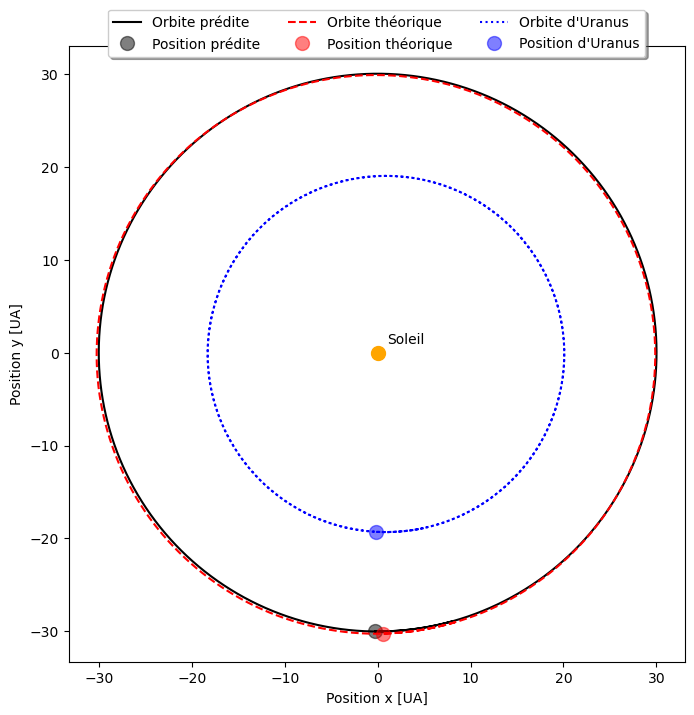

In [59]:
Uxyz = Uranus[buffer:-buffer][filter_buffer:-filter_buffer][buffer_fft:-buffer_fft].T
Ux,Uy,Uz = Uxyz[:,ind_1:ind_2]
Ux1,Uy1 = Ux[0],Uy[0]
r_U1 = np.sqrt(Ux1**2+Uy1**2)
ratio = demi_grand_axe_N/r_U1
Nx1,Ny1 = np.array([Ux1,Uy1])*ratio

theta = np.arctan2(Nx1,Ny1)

# Ici on arrange le time_step (en radian) pour qu'il soit accurate avec la période sidérale de Neptune
time_step = Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_1:ind_2]-Time[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_1:ind_2].min()
time_step = (time_step/time_step.max())*(2*np.pi)*(p_synodic/p_N) - theta


# On assume une orbite circulaire
Nx = np.array([demi_grand_axe_N*-np.sin(t) for t in time_step])
Ny = np.array([demi_grand_axe_N*np.cos(t) for t in time_step])

Neptune2 = Neptune[filter_buffer:-filter_buffer][buffer_fft:-buffer_fft][ind_1:ind_2]

Nx2, Ny2, Nz2 = Neptune2.T


erreur_sur_pos_init = ( np.sqrt((Nx2[0]-Nx[0])**2 + (Ny2[0]-Ny[0])**2)/np.sqrt(Nx2[0]**2+Ny2[0]**2) )*100


min_erreur = 100
max_erreur = 0
for t in range(len(Nx)):
    erreur_sur_pos = ( np.sqrt((Nx2[t]-Nx[t])**2 + (Ny2[t]-Ny[t])**2)/np.sqrt(Nx2[t]**2+Ny2[t]**2) )*100
    if erreur_sur_pos < min_erreur:
        min_erreur = erreur_sur_pos
    if erreur_sur_pos > max_erreur:
        max_erreur = erreur_sur_pos

print(56*"#"+"\n"+56*"#")
print("L'erreur sur la position à la conjonction est de :",np.round(erreur_sur_pos_init,2),"%")
print(56*"#"+"\n"+56*"#")
print("L'erreur sur la position dans la simulation entre")
print("les deux conjonctions varie entre", np.round(min_erreur,2),"% et", np.round(max_erreur,2),"%")
print(56*"#"+"\n"+56*"#")


fig = plt.figure(figsize=(8,8))
plt.axis('square')
plt.plot(Nx,Ny, 'k', label='Orbite prédite')
plt.plot(Nx[0],Ny[0], 'k', label = 'Position prédite',linestyle="None",marker="o", alpha=0.5, markersize=10)
plt.plot(Nx2, Ny2, 'r--', label = 'Orbite théorique')
plt.plot(Nx2[0], Ny2[0], 'ro', label = 'Position théorique', alpha=0.5, markersize=10)
plt.plot(Ux,Uy,'b', label ="Orbite d'Uranus",linestyle="dotted")
plt.plot(Ux[0], Uy[0],'b', label = "Position d'Uranus",alpha=0.5,marker="o",markersize=10,linestyle="None")
plt.plot(0,0, 'orange', marker='o', markersize=10)
plt.text(1, 1, 'Soleil')
plt.xlabel('Position x [UA]')
plt.ylabel('Position y [UA]')
plt.axis('square')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07),ncol=3, fancybox=True, shadow=True)
plt.show()